In [1]:
# %%
from pathlib import Path

import numpy as np
import scvelo as scv
import torch

from deepvelo.utils import (
    velocity,
    velocity_confidence,
    latent_time,
    update_dict,
    save_model_and_config,
    cross_boundary_correctness,
)
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants


# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2

Using backend: pytorch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load hindbrain data and preprocess


In [2]:
adata = scv.read("deepvelo_data/h5ad_files/Hindbrain_GABA_Glio.h5ad", cache=True)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 45980 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:20) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# DeepVelo


In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)


The ratio of spliced reads is 66.6% (less than 70%). Suggest using coeff_s 0.5.


In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)


computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([13501, 2000])


velo_mat shape: (13501, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [5]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/13501 [00:00<?, ?cells/s]

    finished (0:00:48) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


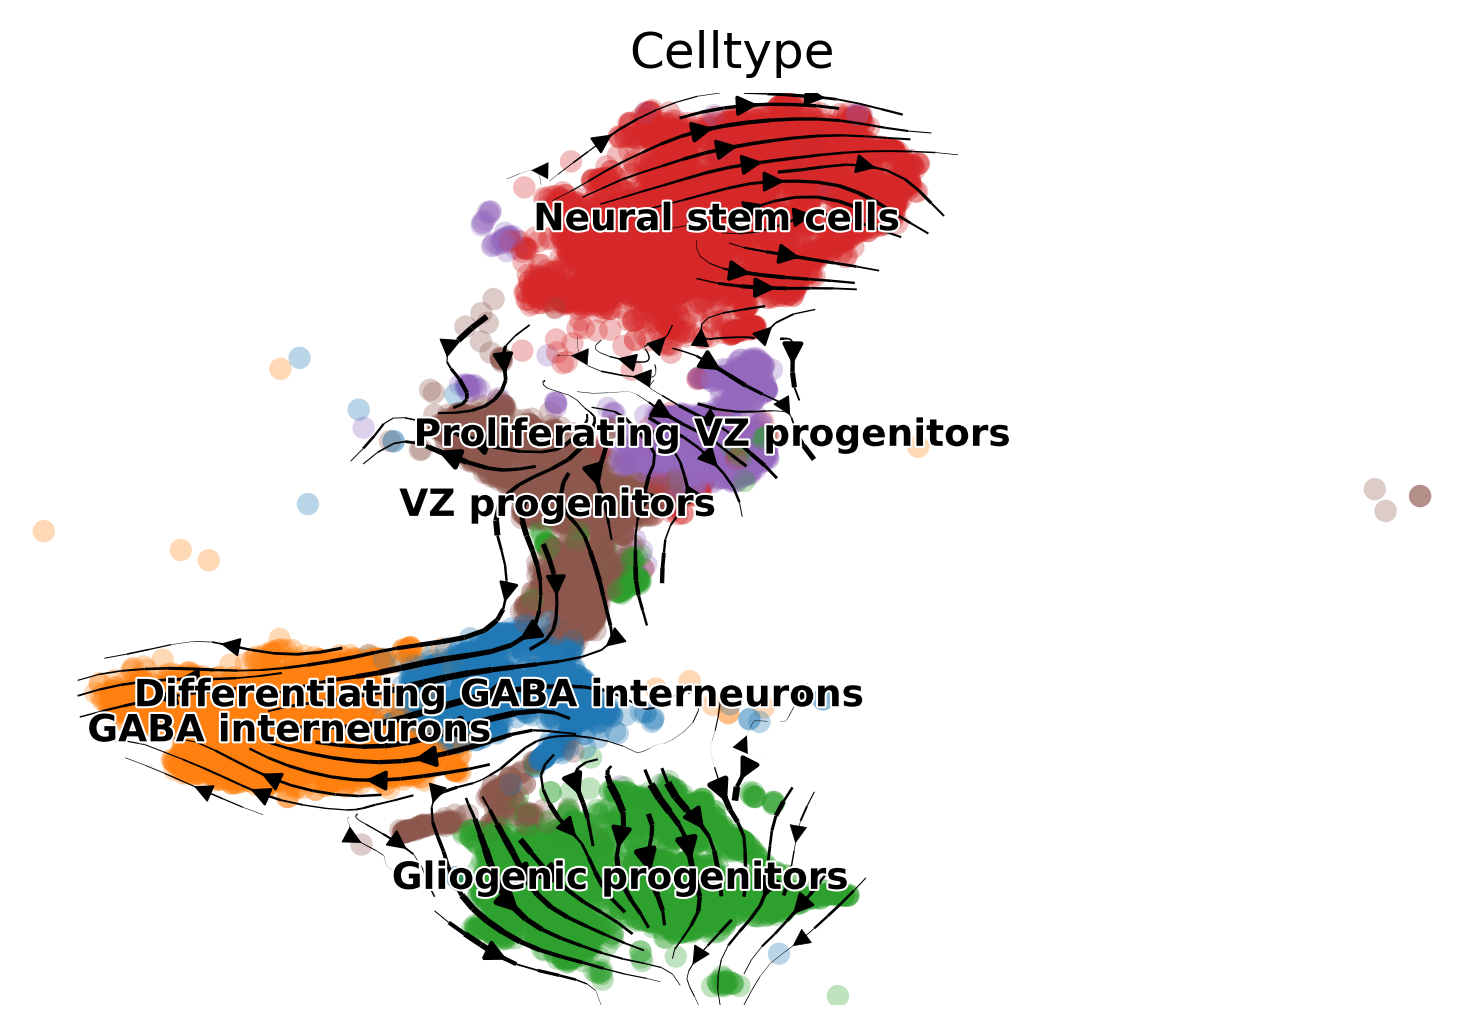

In [6]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="Celltype",
    legend_fontsize=9,
    dpi=150,
)


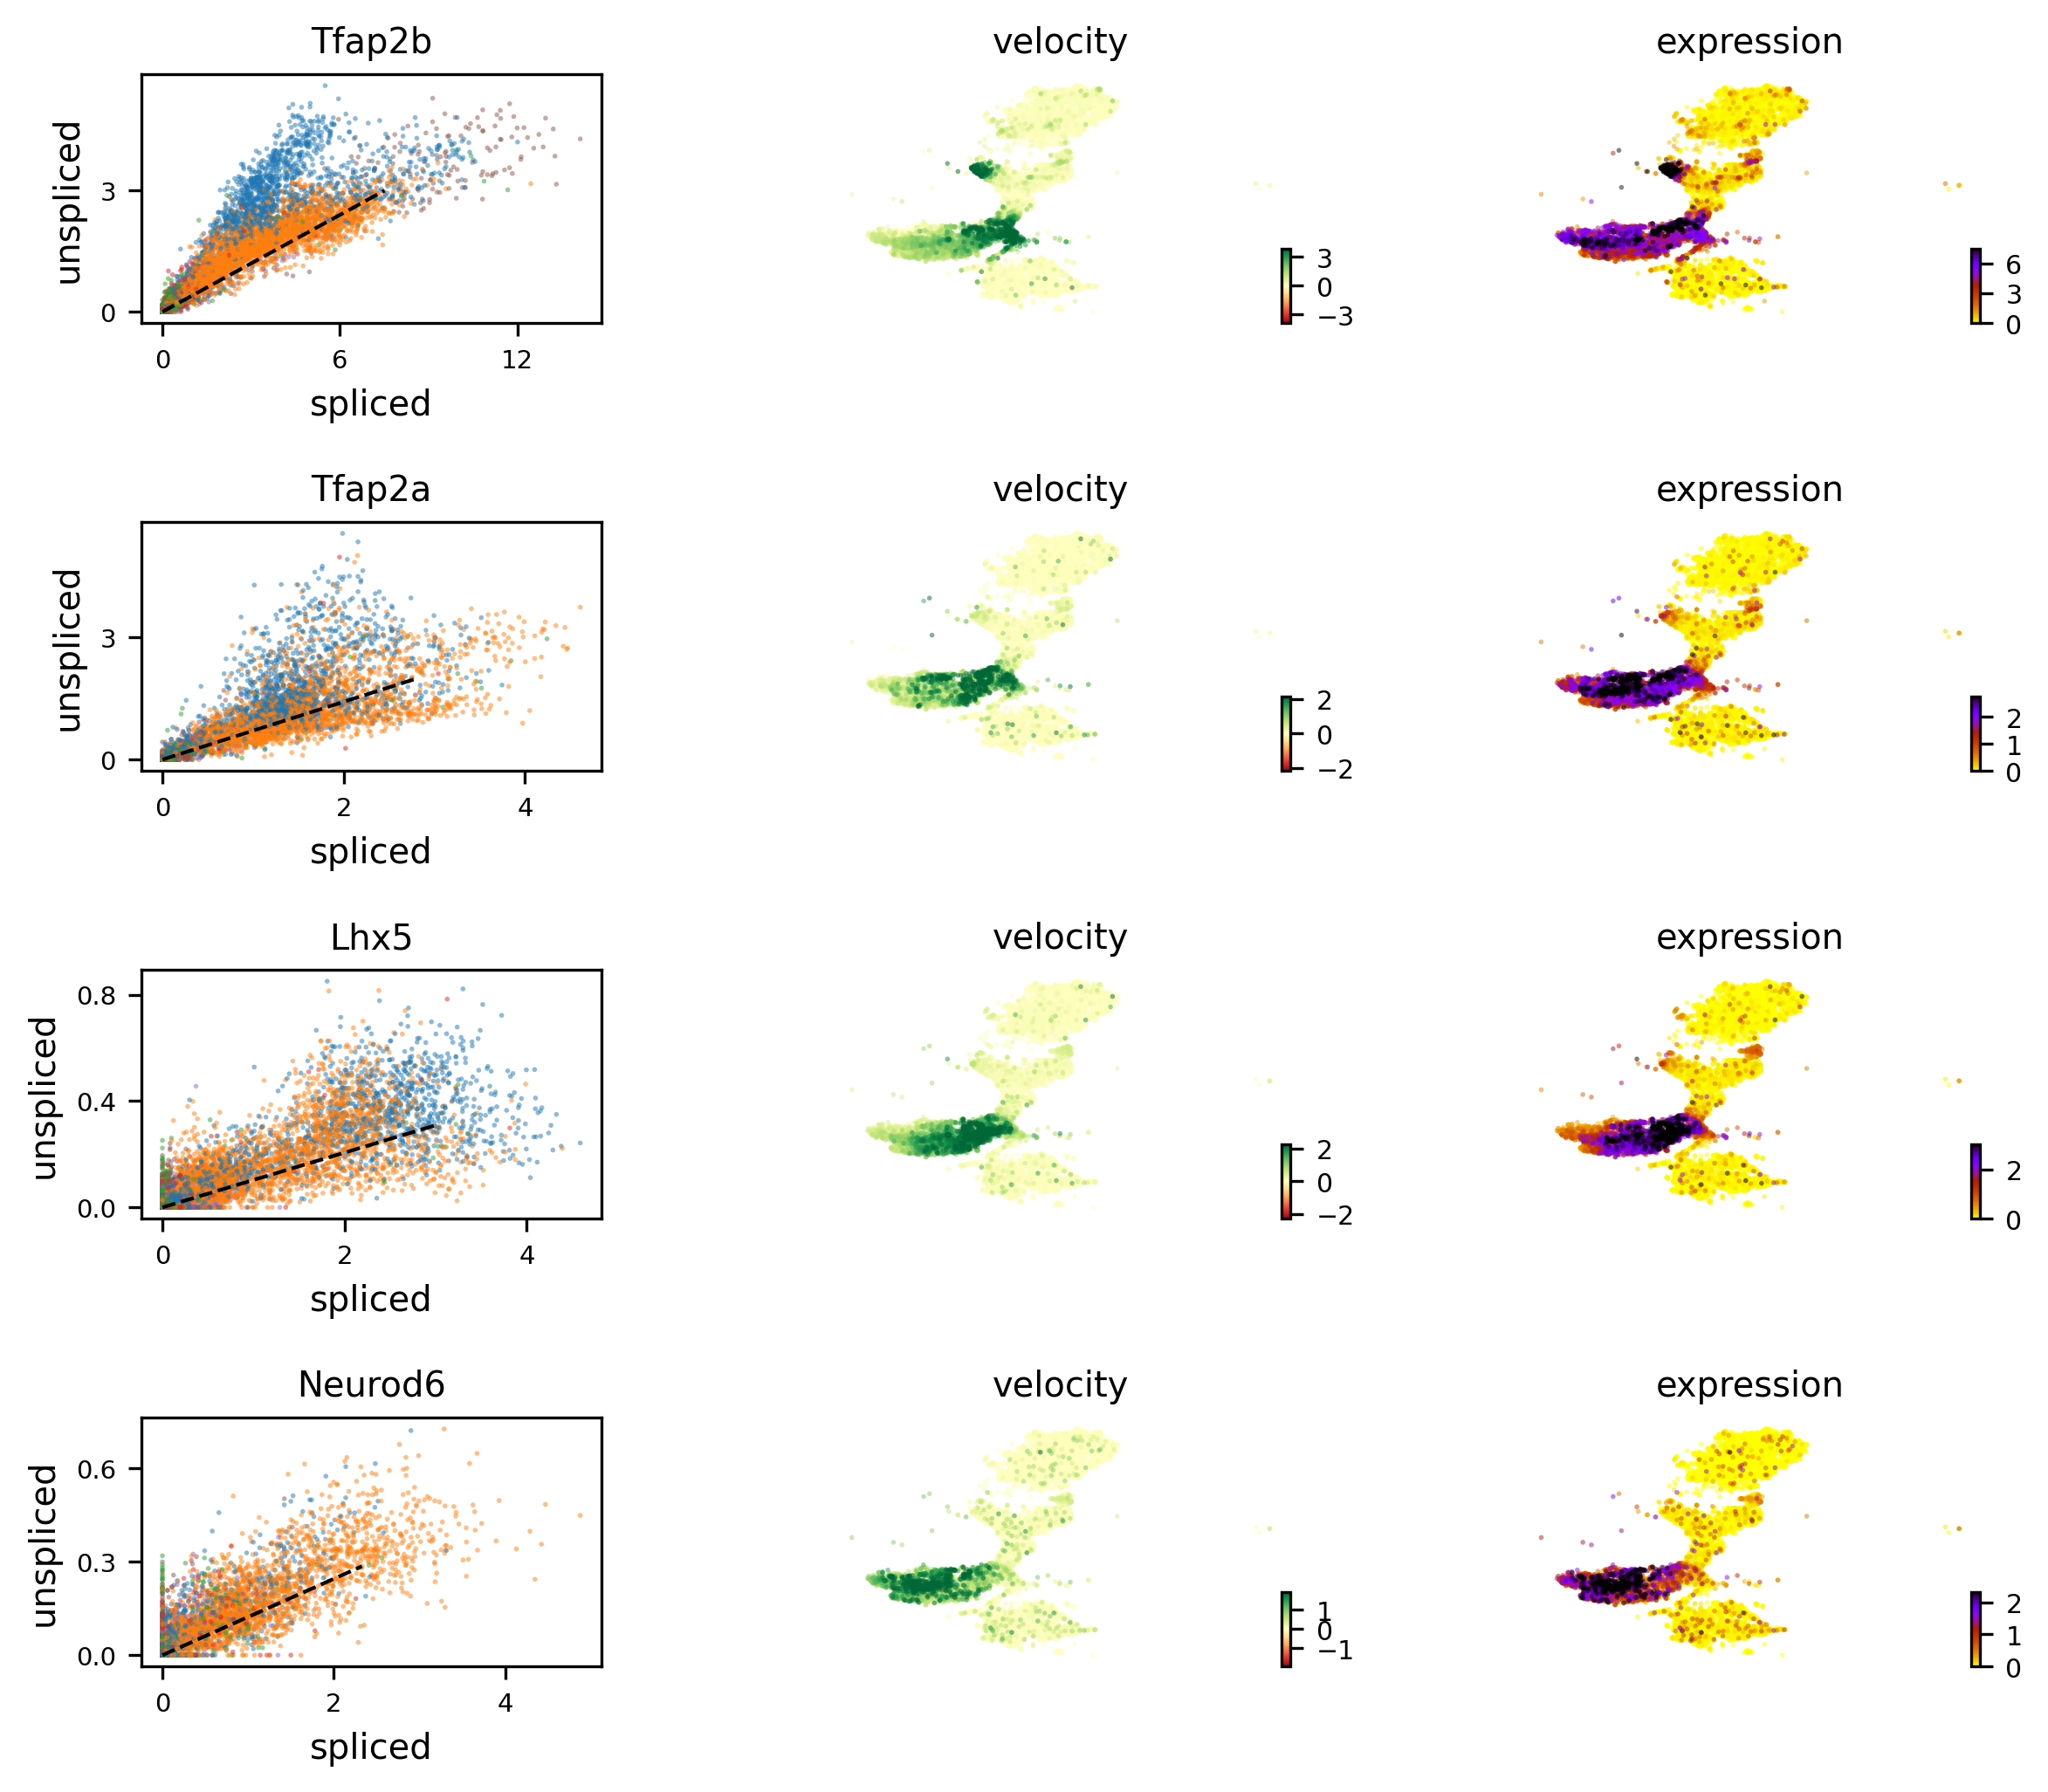

In [7]:
scv.pl.velocity(
    adata,
    var_names=["Tfap2b", "Tfap2a", "Lhx5", "Neurod6"],
    basis="tsne",
    color="Celltype",
    dpi=150,
)


computing terminal states
    identified 0 region of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


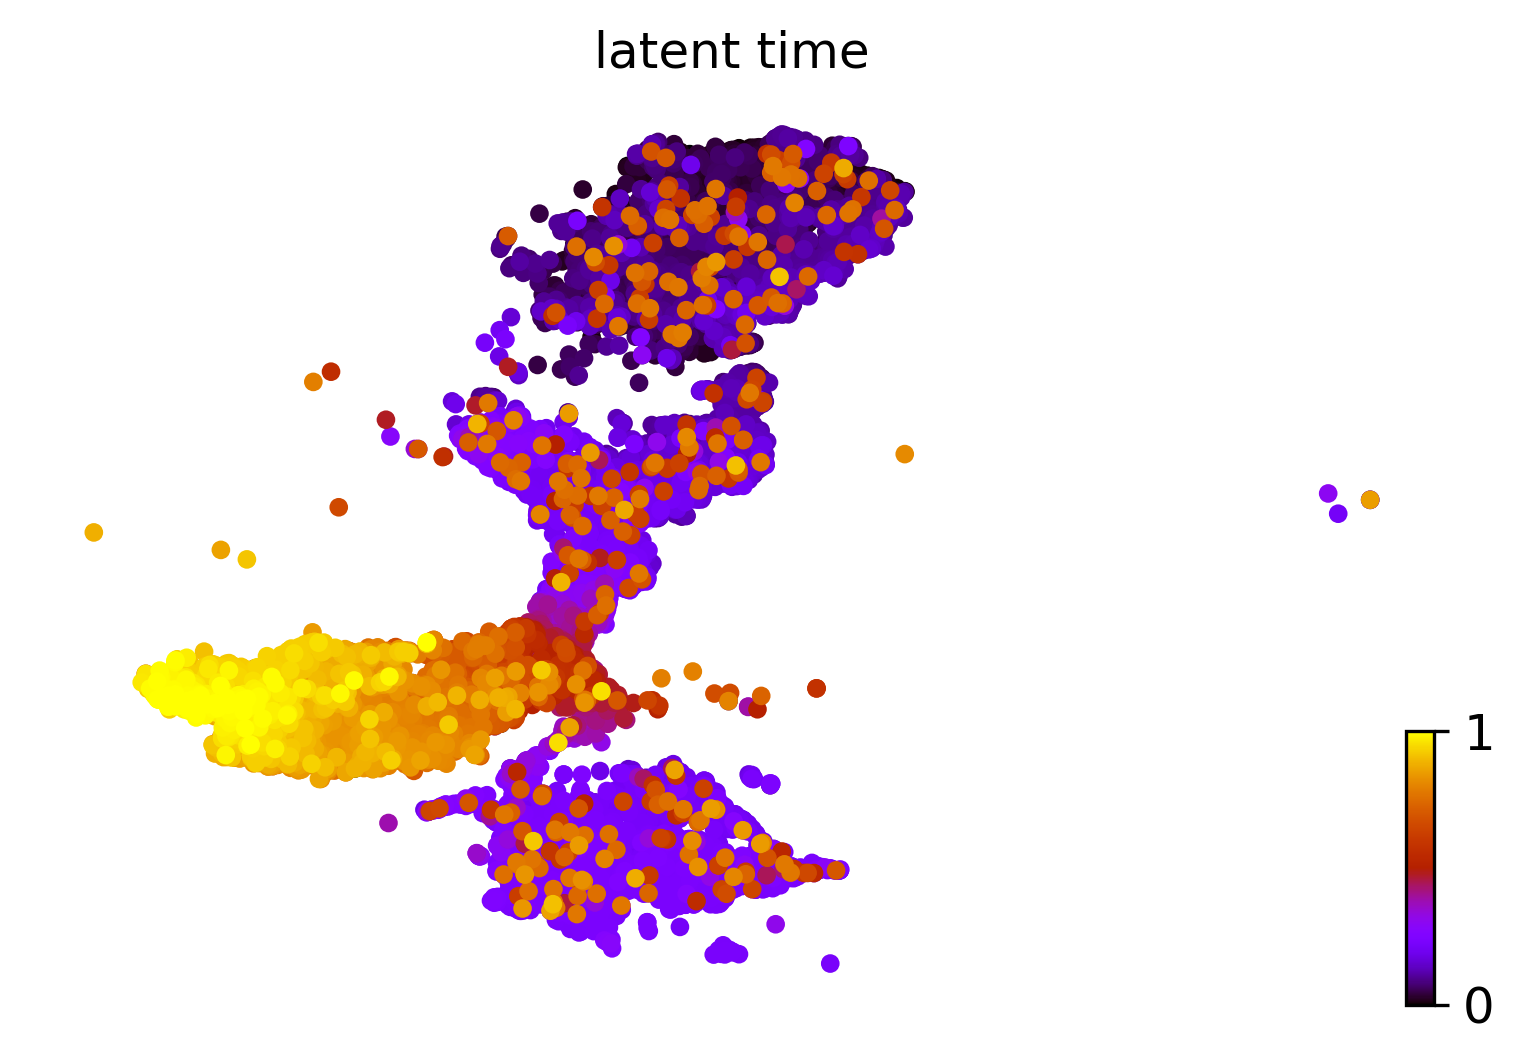

In [8]:
# pseudo-time plot
latent_time(adata)
scv.pl.scatter(
    adata,
    color="latent_time",
    color_map="gnuplot",
    size=80,
    dpi=150,
)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


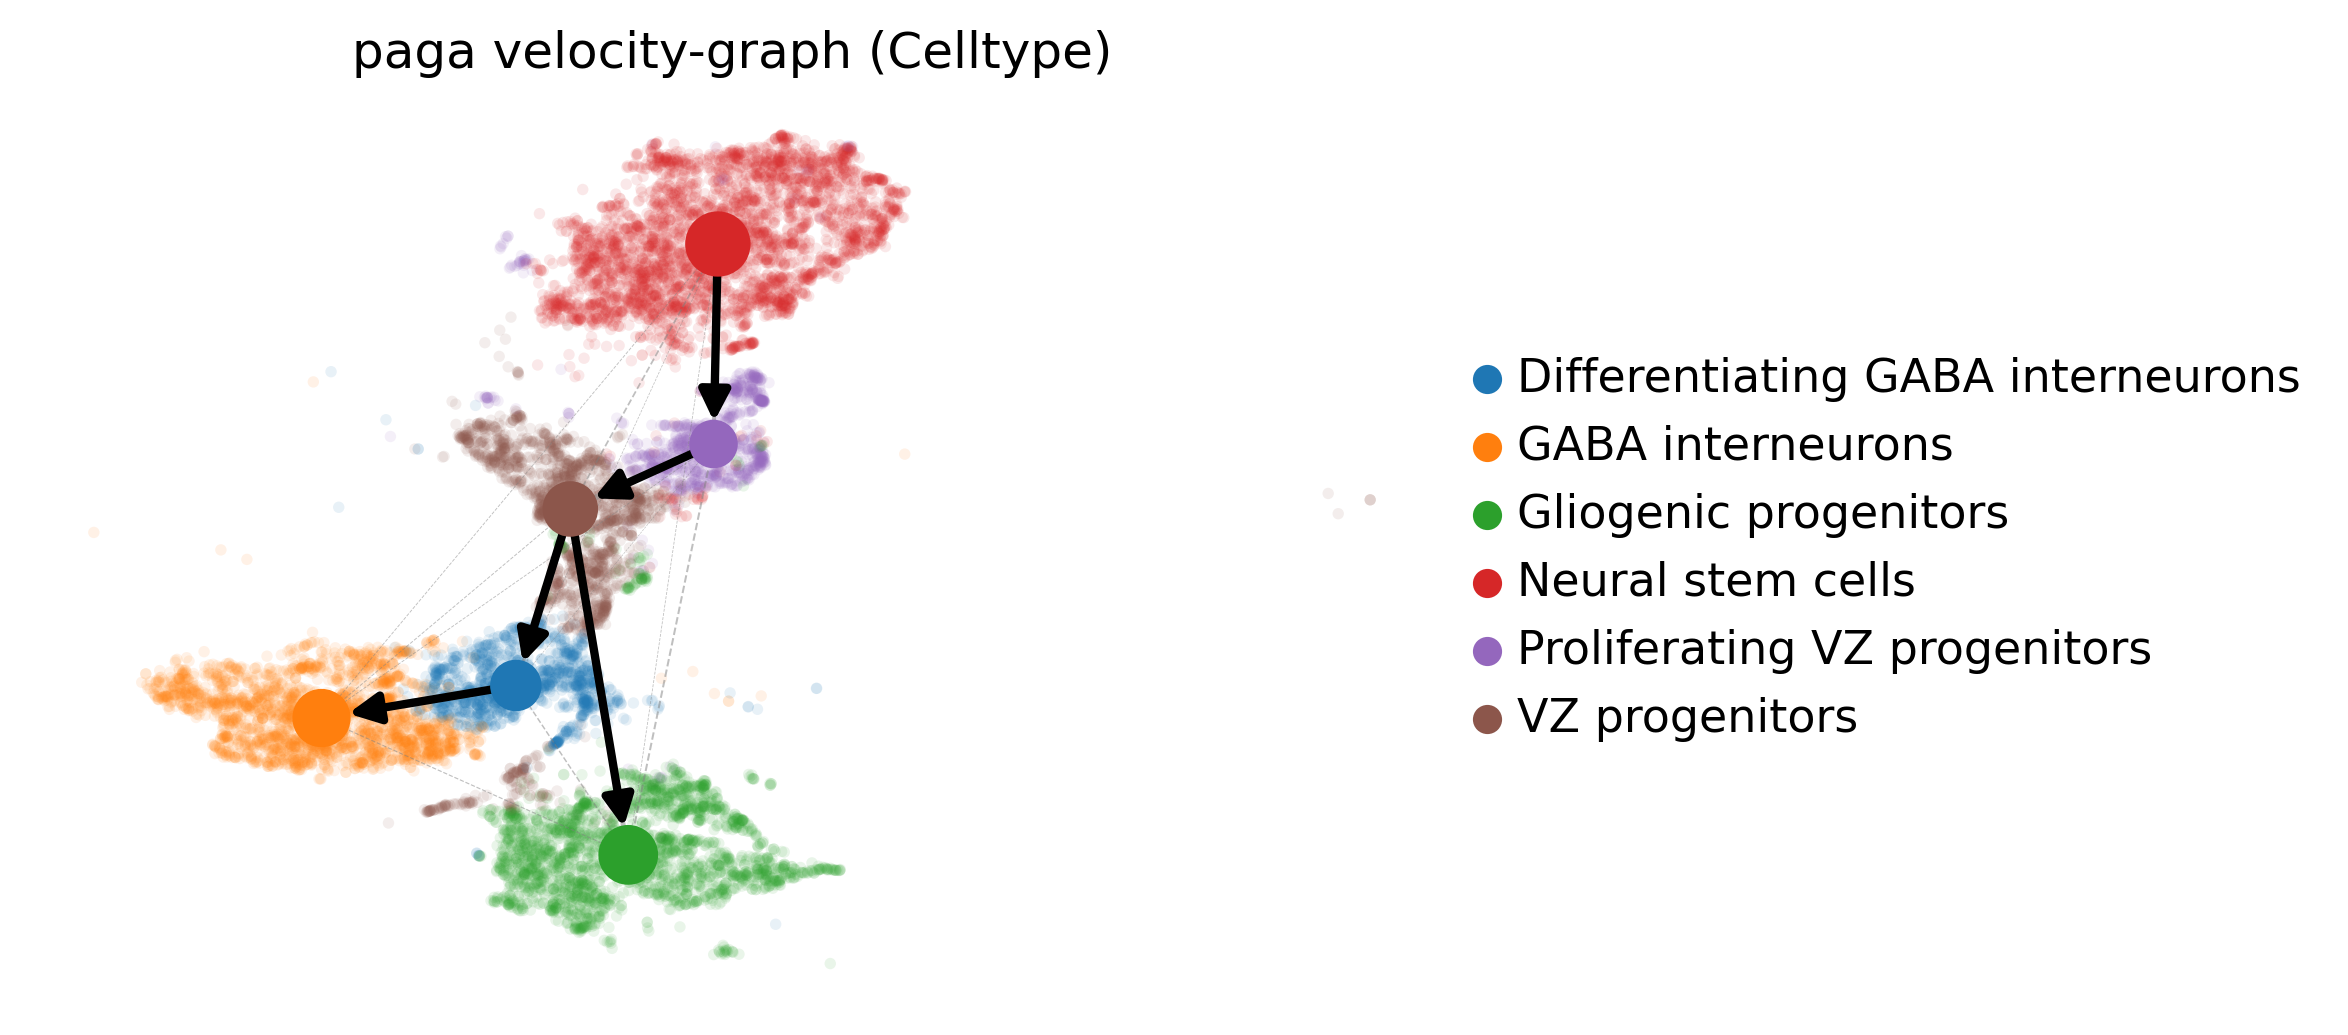

In [9]:
# trajectory inference
adata.uns["neighbors"]["distances"] = adata.obsp["distances"]
adata.uns["neighbors"]["connectivities"] = adata.obsp["connectivities"]
scv.tl.paga(adata, groups="Celltype")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [10]:
deepvelo_adata = adata.copy()
save_dir = Path("saved/hindbrain")
save_dir.mkdir(exist_ok=True, parents=True)
deepvelo_adata.write(save_dir / "Hindbrain_GABA_Glio[DeepVelo].h5ad")
# save pytorch model and configs
save_model_and_config(trainer.model, configs, save_dir)


# scVelo (dynamical)


In [11]:
adata = scv.read("../data/Hindbrain_GABA_Glio.h5ad", cache=True)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 45980 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")


recovering dynamics (using 8/8 cores)


  0%|          | 0/1325 [00:00<?, ?gene/s]

    finished (0:08:28) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/13501 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:04) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


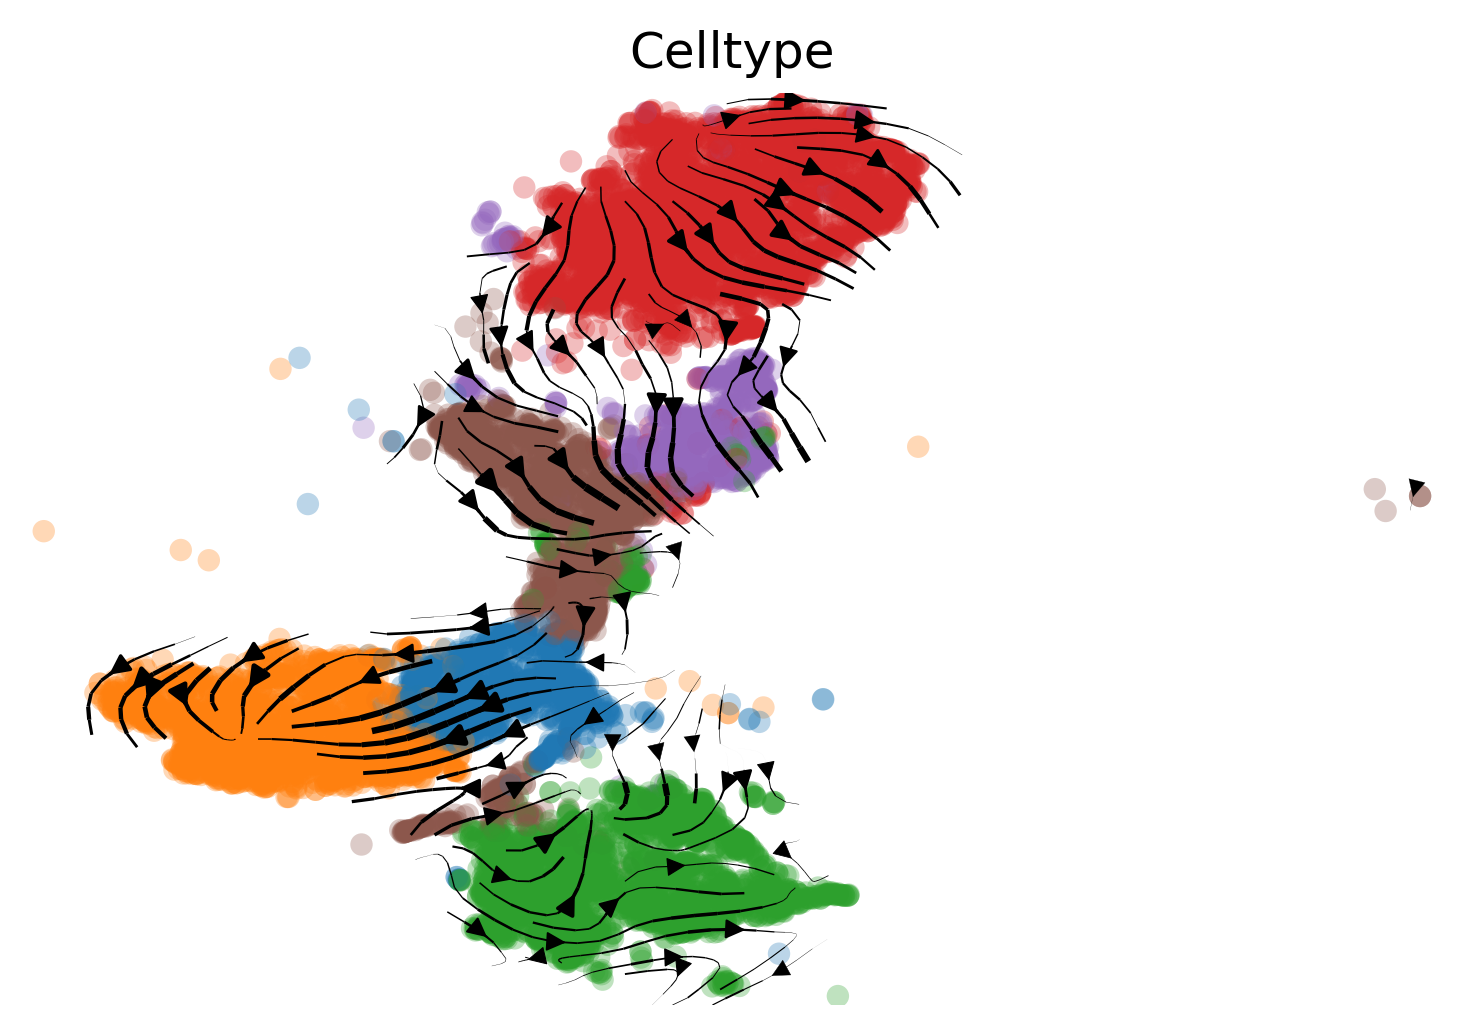

In [14]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="Celltype",
    legend_loc="none",
    legend_fontsize=9,
    dpi=150,
)


computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


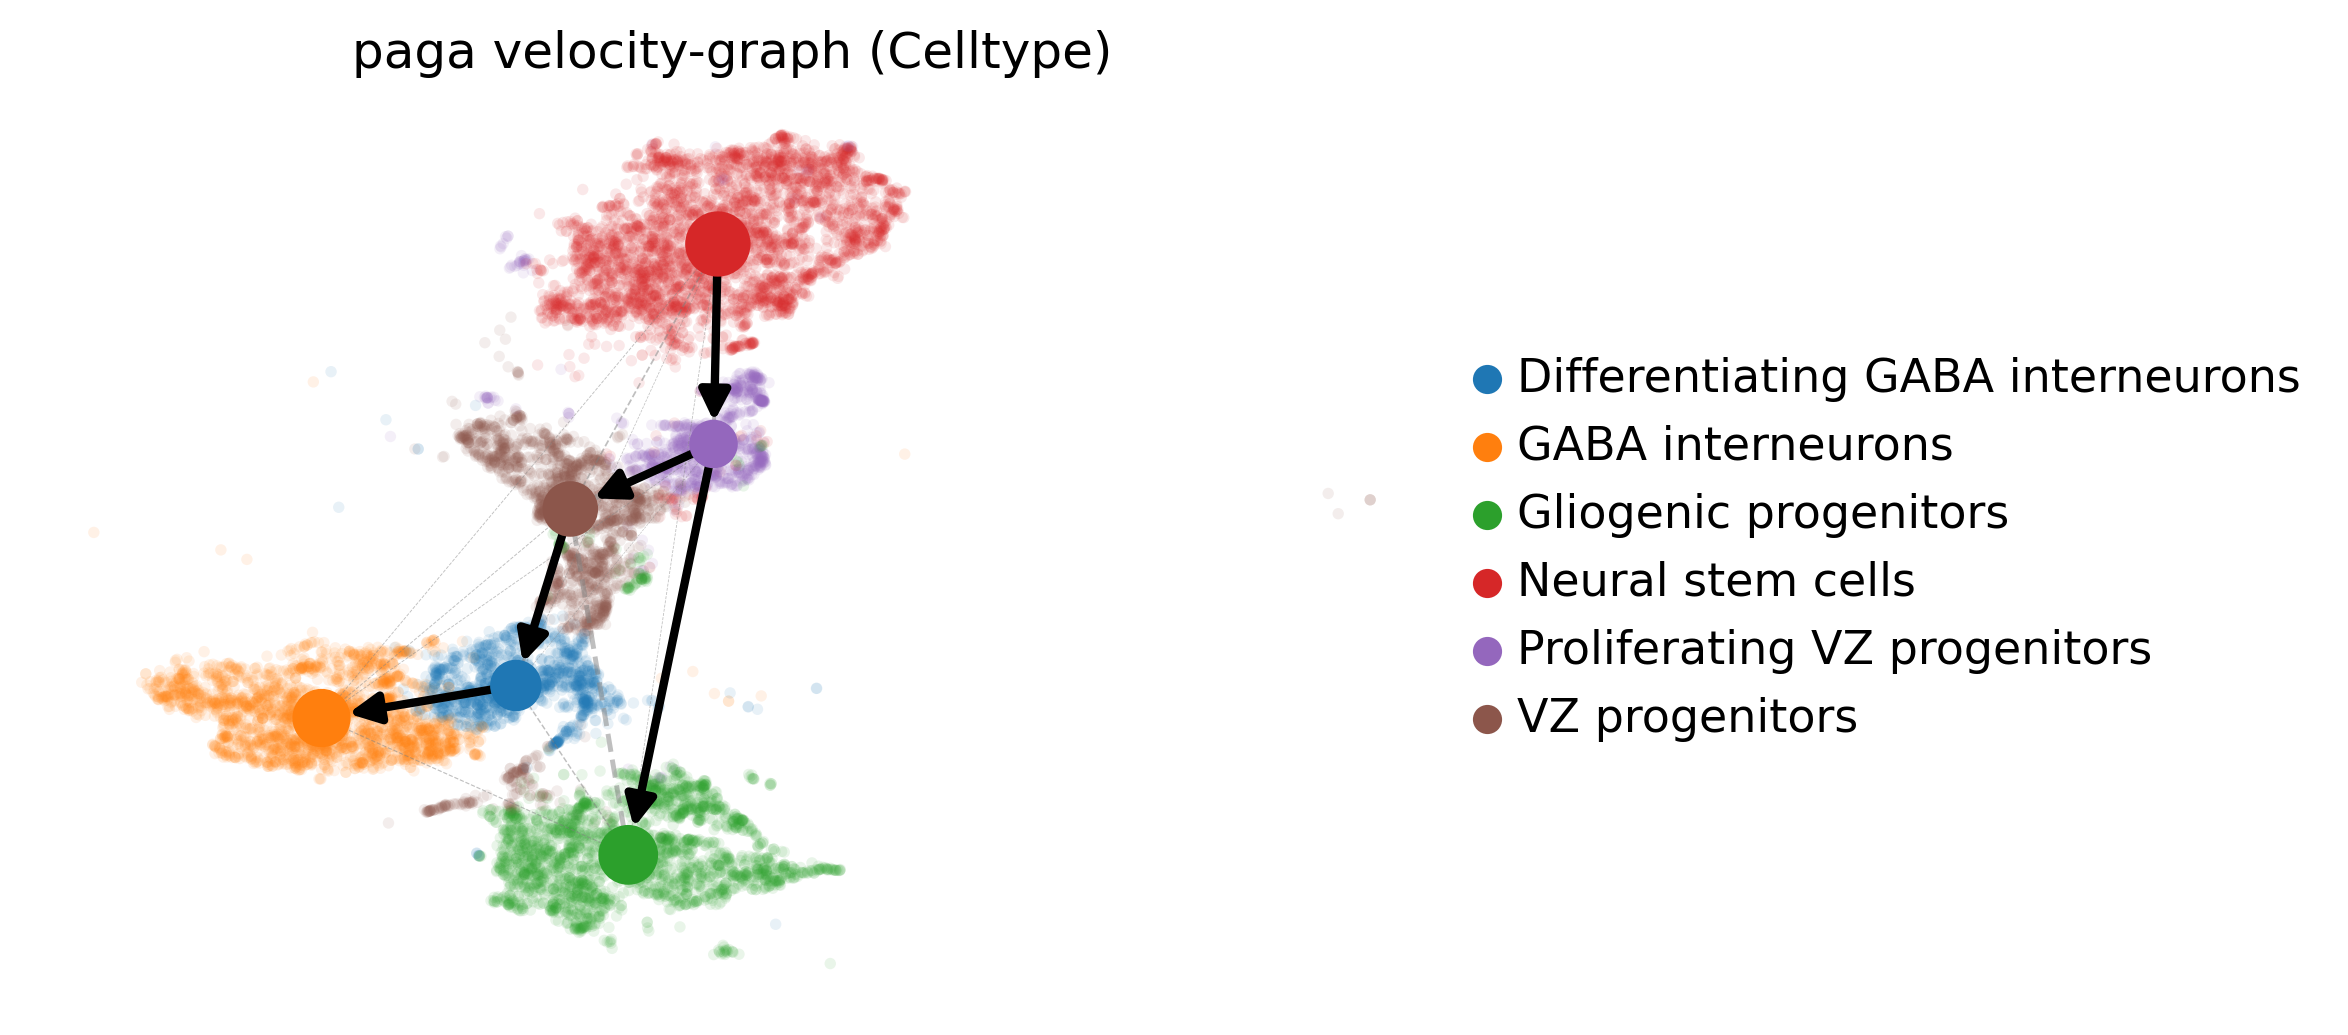

In [15]:
scv.tl.paga(adata, groups="Celltype")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [16]:
# save adata for next steps
dynamical_adata = adata.copy()


# Compare direction scores

In [17]:
cluster_edges = [
    ("Neural stem cells", "Proliferating VZ progenitors"),
    ("Proliferating VZ progenitors", "VZ progenitors"),
    ("VZ progenitors", "Differentiating GABA interneurons"),
    ("VZ progenitors", "Gliogenic progenitors"),
    ("Differentiating GABA interneurons", "GABA interneurons"),
]
cbcs, avg_cbc = cross_boundary_correctness(
    deepvelo_adata, "Celltype", "velocity", cluster_edges, return_raw=False, x_emb="X_tsne"
)
print(f"Average cross-boundary correctness of DeepVelo: {avg_cbc:.2f}")
cbcs

Average cross-boundary correctness of DeepVelo: 0.32


{('Neural stem cells', 'Proliferating VZ progenitors'): -0.06625719927313369,
 ('Proliferating VZ progenitors', 'VZ progenitors'): 0.18429778844779637,
 ('VZ progenitors', 'Differentiating GABA interneurons'): 0.3914824604197222,
 ('VZ progenitors', 'Gliogenic progenitors'): 0.4786518282904294,
 ('Differentiating GABA interneurons',
  'GABA interneurons'): 0.6251400221515193}

In [18]:
cbcs, avg_cbc = cross_boundary_correctness(
    dynamical_adata, "Celltype", "velocity", cluster_edges, return_raw=False, x_emb="X_tsne"
)
print(f"Average cross-boundary correctness of Dynamical: {avg_cbc:.2f}")
cbcs

Average cross-boundary correctness of Dynamical: 0.32


{('Neural stem cells', 'Proliferating VZ progenitors'): 0.26698581689377354,
 ('Proliferating VZ progenitors', 'VZ progenitors'): 0.2720903700306423,
 ('VZ progenitors', 'Differentiating GABA interneurons'): 0.23239165970113934,
 ('VZ progenitors', 'Gliogenic progenitors'): 0.2207010934638815,
 ('Differentiating GABA interneurons',
  'GABA interneurons'): 0.6245235046422445}

# Compare consistency score


In [19]:
from deepvelo.utils.confidence import velocity_confidence
from deepvelo.utils.plot import statplot, compare_plot


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.9297, std: 0.0461
Dynamical mean score: 0.8713, std: 0.1652


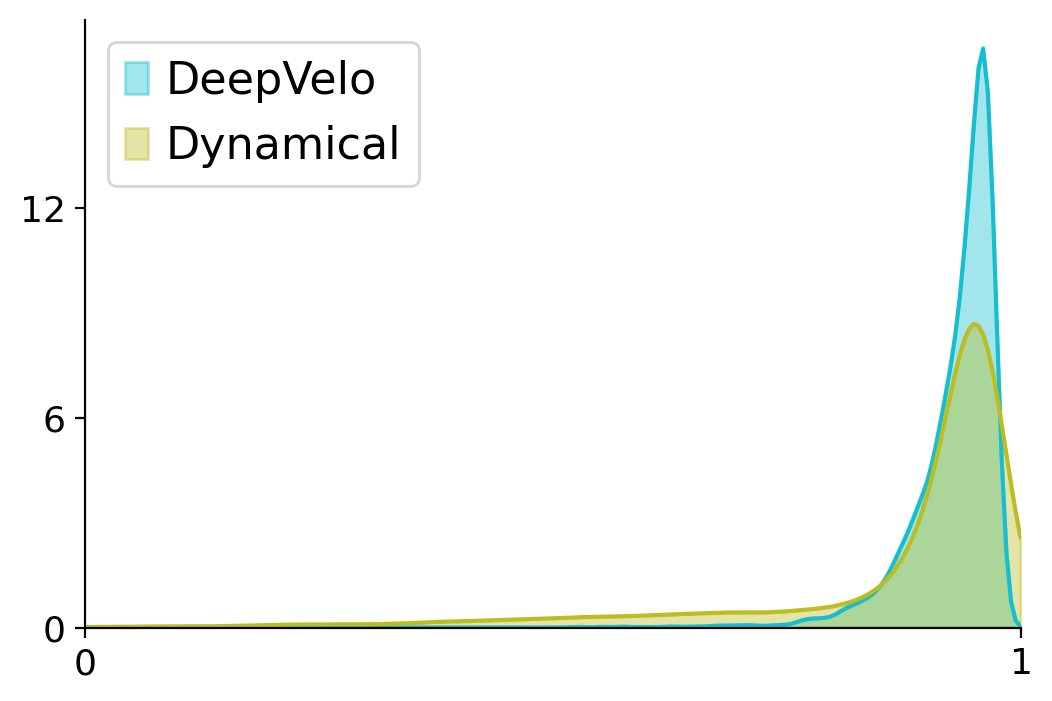

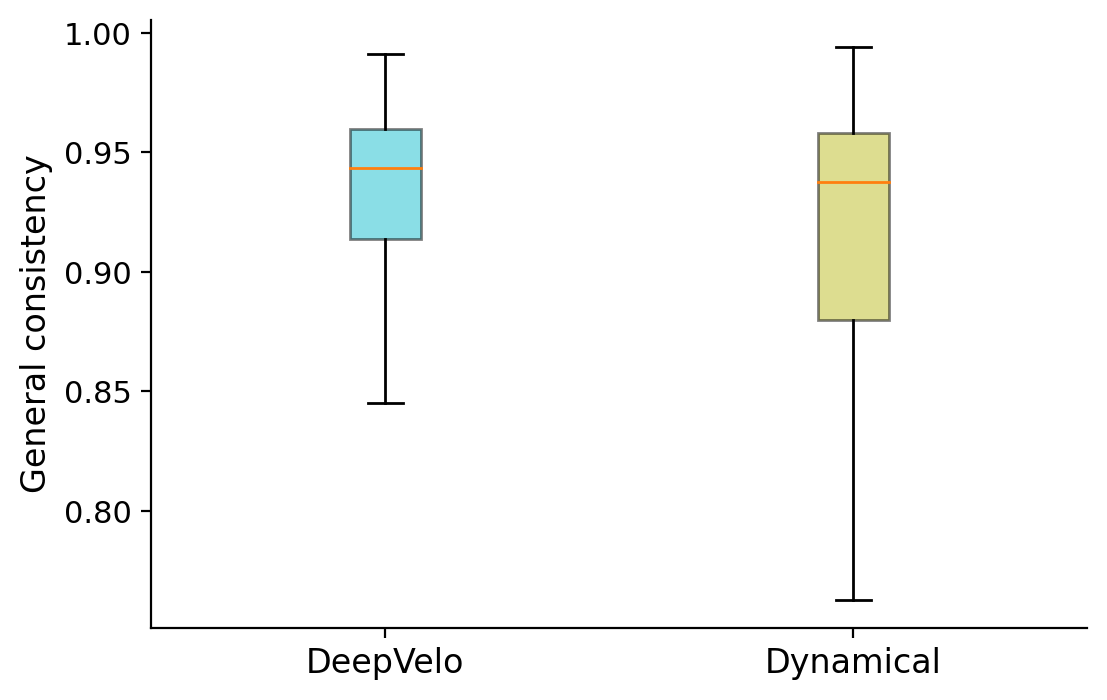

In [20]:
vkey = "velocity"
method = "cosine"
velocity_confidence(deepvelo_adata, vkey=vkey, method=method)
velocity_confidence(dynamical_adata, vkey=vkey, method=method)
compare_plot(deepvelo_adata, dynamical_adata, method=method)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.6190, std: 0.1196
Dynamical mean score: 0.5066, std: 0.3276


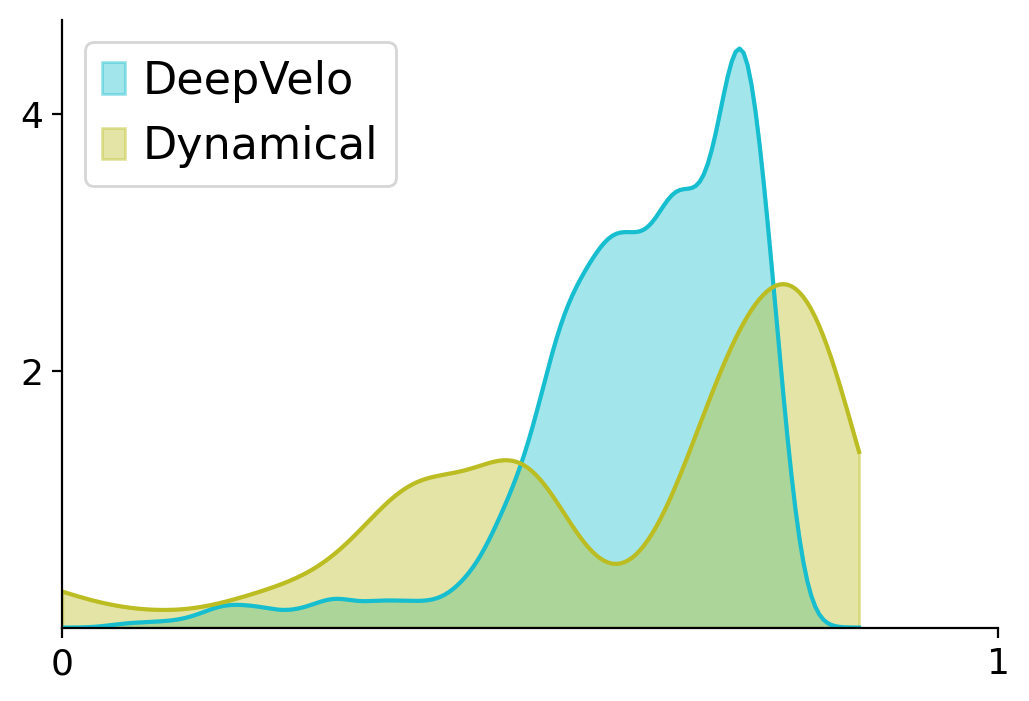

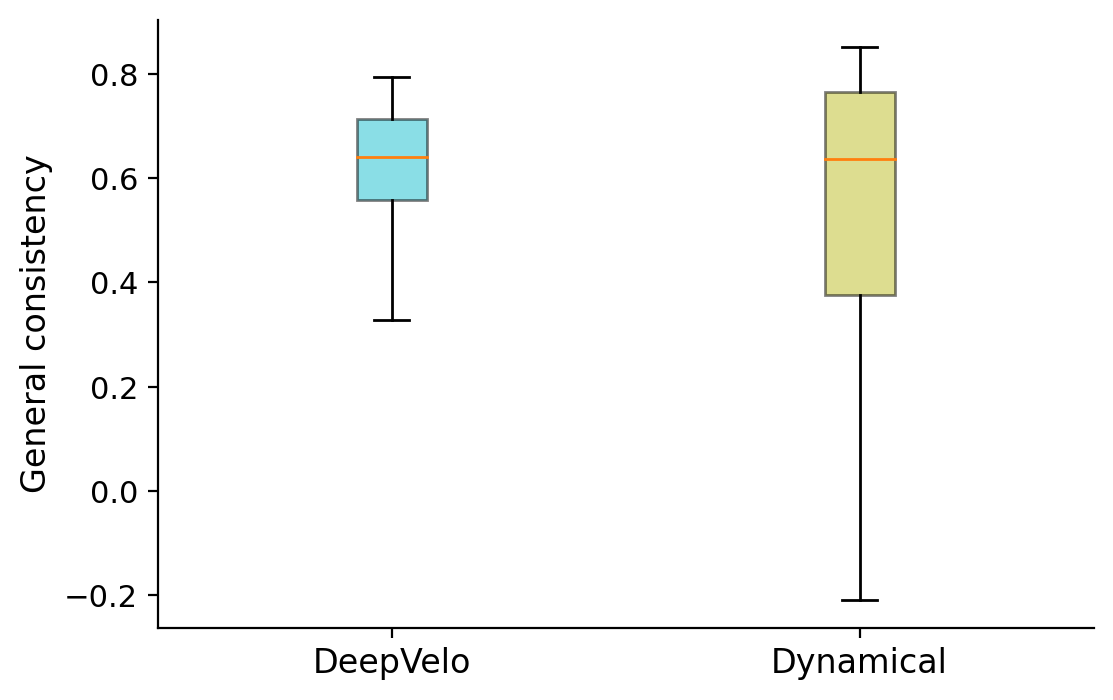

In [21]:
vkey = "velocity"
method = "cosine"
scope_key = "Celltype"
# 3. cosine similarity, compute within Celltype
velocity_confidence(deepvelo_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(dynamical_adata, vkey=vkey, method=method, scope_key=scope_key)
compare_plot(deepvelo_adata, dynamical_adata, method=method)
